In [2]:
#Importing necessary libraries
import pandas as pd
import numpy as np 
from matplotlib import pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.model_selection import train_test_split
import librosa
import os
import shap
import librosa.display
from skimage.io import imread
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.tree import export_text
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

C:\Users\19147\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


In [3]:
import pandas as pd

# Load the CSV file
metadata_path = "C:/Users/19147/Downloads/archive (12)/bird_songs_metadata.csv"
df = pd.read_csv(metadata_path)

# Display the first few rows of the dataframe 
df.head()


,id,genus,species,subspecies,name,recordist,country,location,latitude,longitude,altitude,sound_type,source_url,license,time,date,remarks,filename
0,557838,Thryomanes,bewickii,NaN,Bewick's Wren,Whitney Neufeld-Kaiser,United States,"Arlington, Snohomish County, Washington",48.0708,-122.1006,100,"adult, sex uncertain, song",//www.xeno-canto.org/557838,//creativecommons.org/licenses/by-nc-sa/4.0/,11:51,2020-03-14,"Recorded with Voice Record Pro on iPhone7, nor...",557838-0.wav
1,557838,Thryomanes,bewickii,NaN,Bewick's Wren,Whitney Neufeld-Kaiser,United States,"Arlington, Snohomish County, Washington",48.0708,-122.1006,100,"adult, sex uncertain, song",//www.xeno-canto.org/557838,//creativecommons.org/licenses/by-nc-sa/4.0/,11:51,2020-03-14,"Recorded with Voice Record Pro on iPhone7, nor...",557838-1.wav
2,557838,Thryomanes,bewickii,NaN,Bewick's Wren,Whitney Neufeld-Kaiser,United States,"Arlington, Snohomish County, Washington",48.0708,-122.1006,100,"adult, sex uncertain, song",//www.xeno-canto.org/557838,//creativecommons.org/licenses/by-nc-sa/4.0/,11:51,2020-03-14,"Recorded with Voice Record Pro on iPhone7, nor...",557838-4.wav
3,557838,Thryomanes,bewickii,NaN,Bewick's Wren,Whitney Neufeld-Kaiser,United States,"Arlington, Snohomish County, Washington",48.0708,-122.1006,100,"adult, sex uncertain, song",//www.xeno-canto.org/557838,//creativecommons.org/licenses/by-nc-sa/4.0/,11:51,2020-03-14,"Recorded with Voice Record Pro on iPhone7, nor...",557838-5.wav
4,557838,Thryomanes,bewickii,NaN,Bewick's Wren,Whitney Neufeld-Kaiser,United States,"Arlington, Snohomish County, Washington",48.0708,-122.1006,100,"adult, sex uncertain, song",//www.xeno-canto.org/557838,//creativecommons.org/licenses/by-nc-sa/4.0/,11:51,2020-03-14,"Recorded with Voice Record Pro on iPhone7, nor...",557838-6.wav


In [4]:
#distribution of species
species_dist = df['species'].value_counts()
print(species_dist)

species
melodia        1256
polyglottos    1182
cardinalis     1074
migratorius    1017
bewickii        893
Name: count, dtype: int64


In [5]:
# Checking for missing values in each column
missing_values = df.isnull().sum()
print(missing_values)

id               0
genus            0
species          0
subspecies    3876
name             0
recordist        0
country          0
location         0
latitude        90
longitude       90
altitude        42
sound_type       0
source_url       0
license          0
time             0
date             0
remarks       1859
filename         0
dtype: int64


The primary input for generating spectrograms is the audio file itself. Missing values in metadata (like subspecies, latitude, longitude, altitude, and remarks) won't affect the generation of spectrograms, as long as the audio files (filename) are intact and not missing. 

In [6]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5422 entries, 0 to 5421
Data columns (total 18 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   id          5422 non-null   int64  
 1   genus       5422 non-null   object 
 2   species     5422 non-null   object 
 3   subspecies  1546 non-null   object 
 4   name        5422 non-null   object 
 5   recordist   5422 non-null   object 
 6   country     5422 non-null   object 
 7   location    5422 non-null   object 
 8   latitude    5332 non-null   float64
 9   longitude   5332 non-null   float64
 10  altitude    5380 non-null   object 
 11  sound_type  5422 non-null   object 
 12  source_url  5422 non-null   object 
 13  license     5422 non-null   object 
 14  time        5422 non-null   object 
 15  date        5422 non-null   object 
 16  remarks     3563 non-null   object 
 17  filename    5422 non-null   object 
dtypes: float64(2), int64(1), object(15)
memory usage: 762.6+ KB
None


**Feature Extraction**

In [7]:

def load_bird_sound_paths_from_csv(metadata_path, audio_files_path):
    df = pd.read_csv(metadata_path)
    file_paths = []
    labels = []

    for index, row in df.iterrows():
        file_path = os.path.join(audio_files_path, row['filename'])
        if os.path.exists(file_path):
            file_paths.append(file_path)
            labels.append(row['species'])  # 'species' holds the label
        else:
            print(f"File not found: {file_path}")

    return file_paths, labels

# Usage
metadata_path = "C:/Users/19147/Downloads/archive (12)/bird_songs_metadata.csv"
audio_files_path =  "C:/Users/19147/Downloads/archive (12)/wavfiles"

file_paths, labels = load_bird_sound_paths_from_csv(metadata_path, audio_files_path)
print(file_paths[:5], labels[:5])


['C:/Users/19147/Downloads/archive (12)/wavfiles\\557838-0.wav', 'C:/Users/19147/Downloads/archive (12)/wavfiles\\557838-1.wav', 'C:/Users/19147/Downloads/archive (12)/wavfiles\\557838-4.wav', 'C:/Users/19147/Downloads/archive (12)/wavfiles\\557838-5.wav', 'C:/Users/19147/Downloads/archive (12)/wavfiles\\557838-6.wav'] ['bewickii', 'bewickii', 'bewickii', 'bewickii', 'bewickii']


In [8]:
# New function to load and process audio files from paths
def load_and_process_audio(file_paths, sr, fixed_length):
    processed_audio = []
    for file_path in file_paths:
        sound, _ = librosa.load(file_path, sr=sr)
        if len(sound) > fixed_length:
            sound = sound[:fixed_length]
        else:
            padding = fixed_length - len(sound)
            sound = np.pad(sound, (0, padding), 'constant')
        processed_audio.append(sound)
    return processed_audio

In [9]:
def extract_combined_features(file_path, sr):
    # Load the audio file first
    audio, sr = librosa.load(file_path, sr=sr)
    
    # Extract MFCC features
    mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=13)
    mfcc_mean = np.mean(mfcc, axis=1)

    # Extract Log Mel Spectrogram features
    mel_spec = librosa.feature.melspectrogram(y=audio, sr=sr, n_mels=128)
    log_mel_spec = librosa.power_to_db(mel_spec)
    log_mel_spec_mean = np.mean(log_mel_spec, axis=1)

    # Combine all features
    combined_features = np.concatenate((mfcc_mean, log_mel_spec_mean))
    return combined_features

In [10]:
sr = 22050  
features_list = [extract_combined_features(fp, sr) for fp in file_paths]
# Convert feature list to numpy array
features_array = np.array(features_list)

label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)

# Split the dataset into training and testing sets
X3_train, X3_test, y3_train, y3_test, files_train, files_test = train_test_split(
    features_array, encoded_labels, file_paths, test_size=0.2, random_state=42
)

Accuracy: 0.8949308755760369
Classification Report:
              precision    recall  f1-score   support

    bewickii       0.89      0.88      0.88       193
  cardinalis       0.87      0.88      0.87       204
     melodia       0.87      0.90      0.88       243
 migratorius       0.92      0.94      0.93       207
 polyglottos       0.93      0.87      0.90       238

    accuracy                           0.89      1085
   macro avg       0.90      0.90      0.89      1085
weighted avg       0.90      0.89      0.89      1085



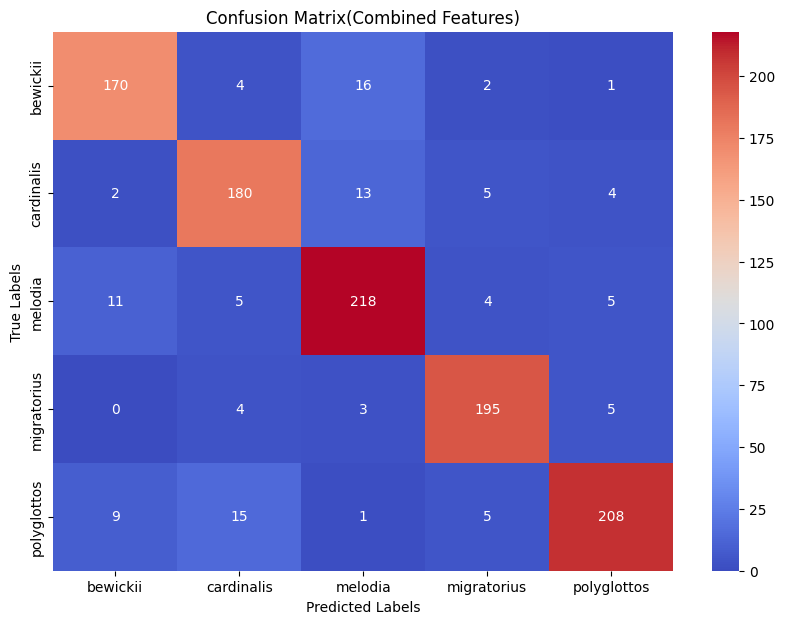

In [11]:

clf_combined = RandomForestClassifier(random_state=42)
clf_combined.fit(X3_train, y3_train)

Combined_predictions = clf_combined.predict(X3_test)

# Print accuracy and classification report
print("Accuracy:", accuracy_score(y3_test, Combined_predictions))
print("Classification Report:")
print(classification_report(y3_test, Combined_predictions, target_names=label_encoder.classes_))

# Confusion Matrix
conf_matrix = confusion_matrix(y3_test, Combined_predictions)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='coolwarm', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Labels')
plt.ylabel(' True Labels ')
plt.title('Confusion Matrix(Combined Features)')
plt.show()


The classification model shows a high overall accuracy of 89.49%, indicating strong performance in identifying bird species. Specifically, 'migratorius' and 'polyglottos' exhibit the best precision scores, at 92% and 93% respectively, highlighting their reliability in predictions. Notably, 'migratorius' also achieves the highest F1-score of 93%, suggesting an excellent balance between precision and recall. Each species shows consistently high performance, with F1-scores ranging from 87% to 93%, underscoring the model's effectiveness across different types of bird calls. This robust performance makes the model highly suitable for applications requiring precise bird species identification.

In [11]:
# Calculate probabilities and find maximum confidence predictions
probs = clf_combined.predict_proba(X3_test)
max_probs = np.max(probs, axis=1)

# Top 10, bottom 10, and incorrect indices
top_10_indices = np.argsort(-max_probs)[:10]
print("top 10 indices:",top_10_indices)
bottom_10_indices = np.argsort(max_probs)[:10]
print("bottom_10_indices:", bottom_10_indices)
incorrect_indices = np.where(Combined_predictions != y3_test)[0]
print("incorrect indices:",incorrect_indices)

top 10 indices: [123 208   7 673 963  36 224 966 854 627]
bottom_10_indices: [ 70 402 476 188 862 987 136 974 689  11]
incorrect indices: [  11   27   50   56   61   64   70   82   93  102  106  114  119  122
  129  136  145  162  176  179  180  188  202  204  205  206  210  221
  235  268  285  287  299  324  334  336  363  364  391  400  401  402
  404  410  413  427  454  455  477  478  486  495  513  543  558  569
  570  572  574  576  579  586  588  622  636  645  650  652  658  662
  680  683  705  713  729  747  750  753  760  762  769  779  788  804
  807  817  825  833  851  862  869  888  893  911  927  931  933  946
  948  962  969  972  974  984  987  993 1038 1049 1051 1060 1066 1068
 1072 1076]


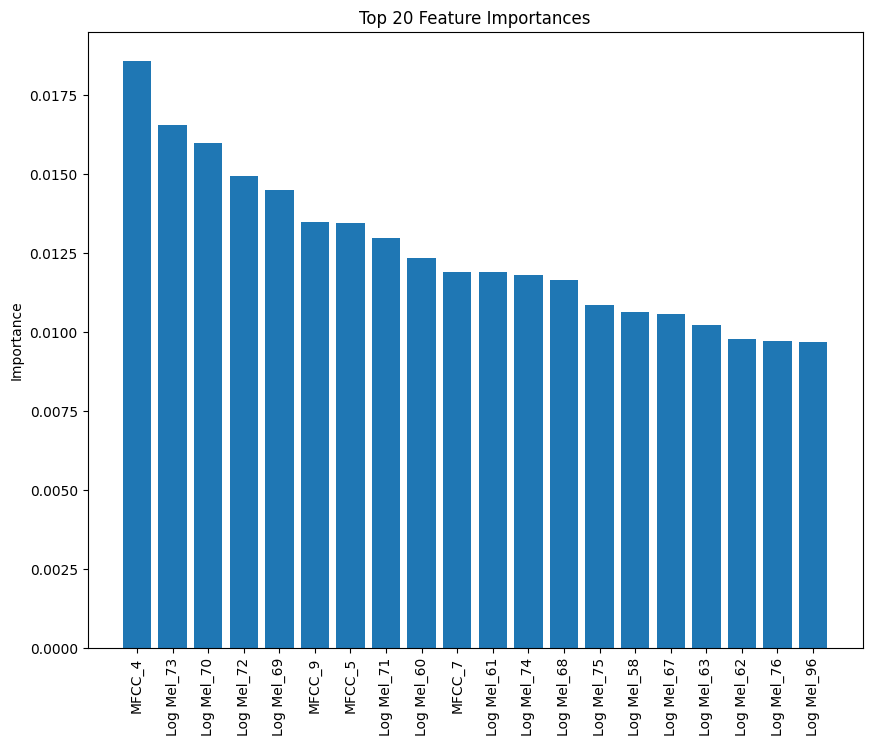

In [12]:

feature_names = ['MFCC_{}'.format(i) for i in range(13)] + \
                ['Log Mel_{}'.format(i) for i in range(128)] 

importances = clf_combined.feature_importances_
indices = np.argsort(importances)[::-1]  

# Plotting top N features
N = 20
plt.figure(figsize=(10, 8))
plt.bar(range(N), importances[indices[:N]], align='center')
plt.xticks(range(N), [feature_names[i] for i in indices[:N]], rotation=90)
plt.title('Top 20 Feature Importances')
plt.ylabel('Importance')
plt.show()


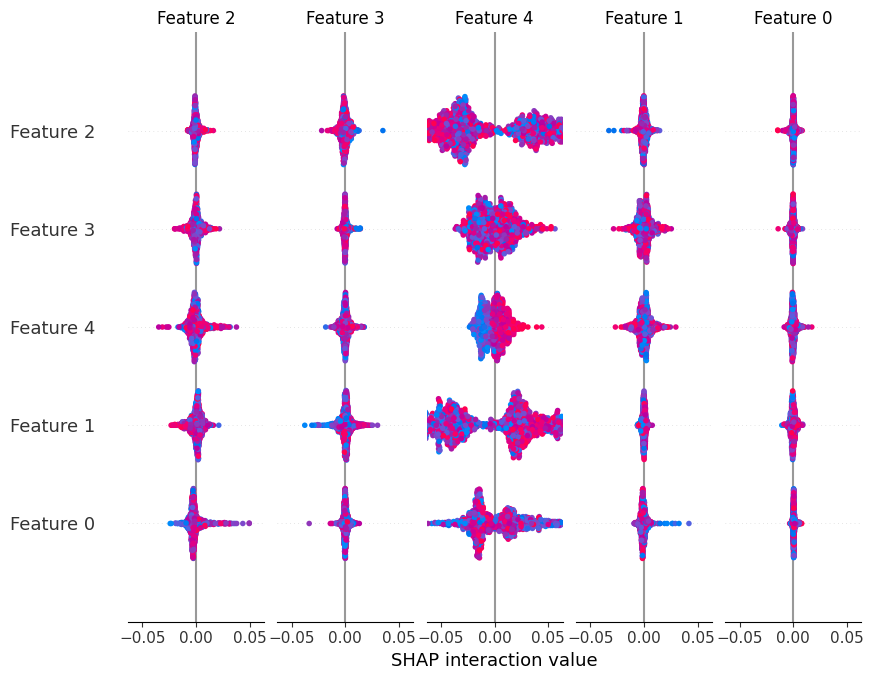

In [13]:

X3_test = np.array(X3_test)

# Create SHAP explainer and compute SHAP values
explainer = shap.TreeExplainer(clf_combined)
shap_values = explainer.shap_values(X3_test)
# Plot summary of SHAP values
shap.summary_plot(shap_values, X3_test)


A SHAP (SHapley Additive exPlanations) dependency plot is a visualization tool used to analyze the relationship between the features of a machine learning model and their impact on the prediction output. Each cell in the plot matrix represents the interaction between a pair of features. For example, the cell at the intersection of Feature 2 row and Feature 3 column shows how Feature 2 and Feature 3 together affect the model's output when they vary together, compared to when they vary independently.

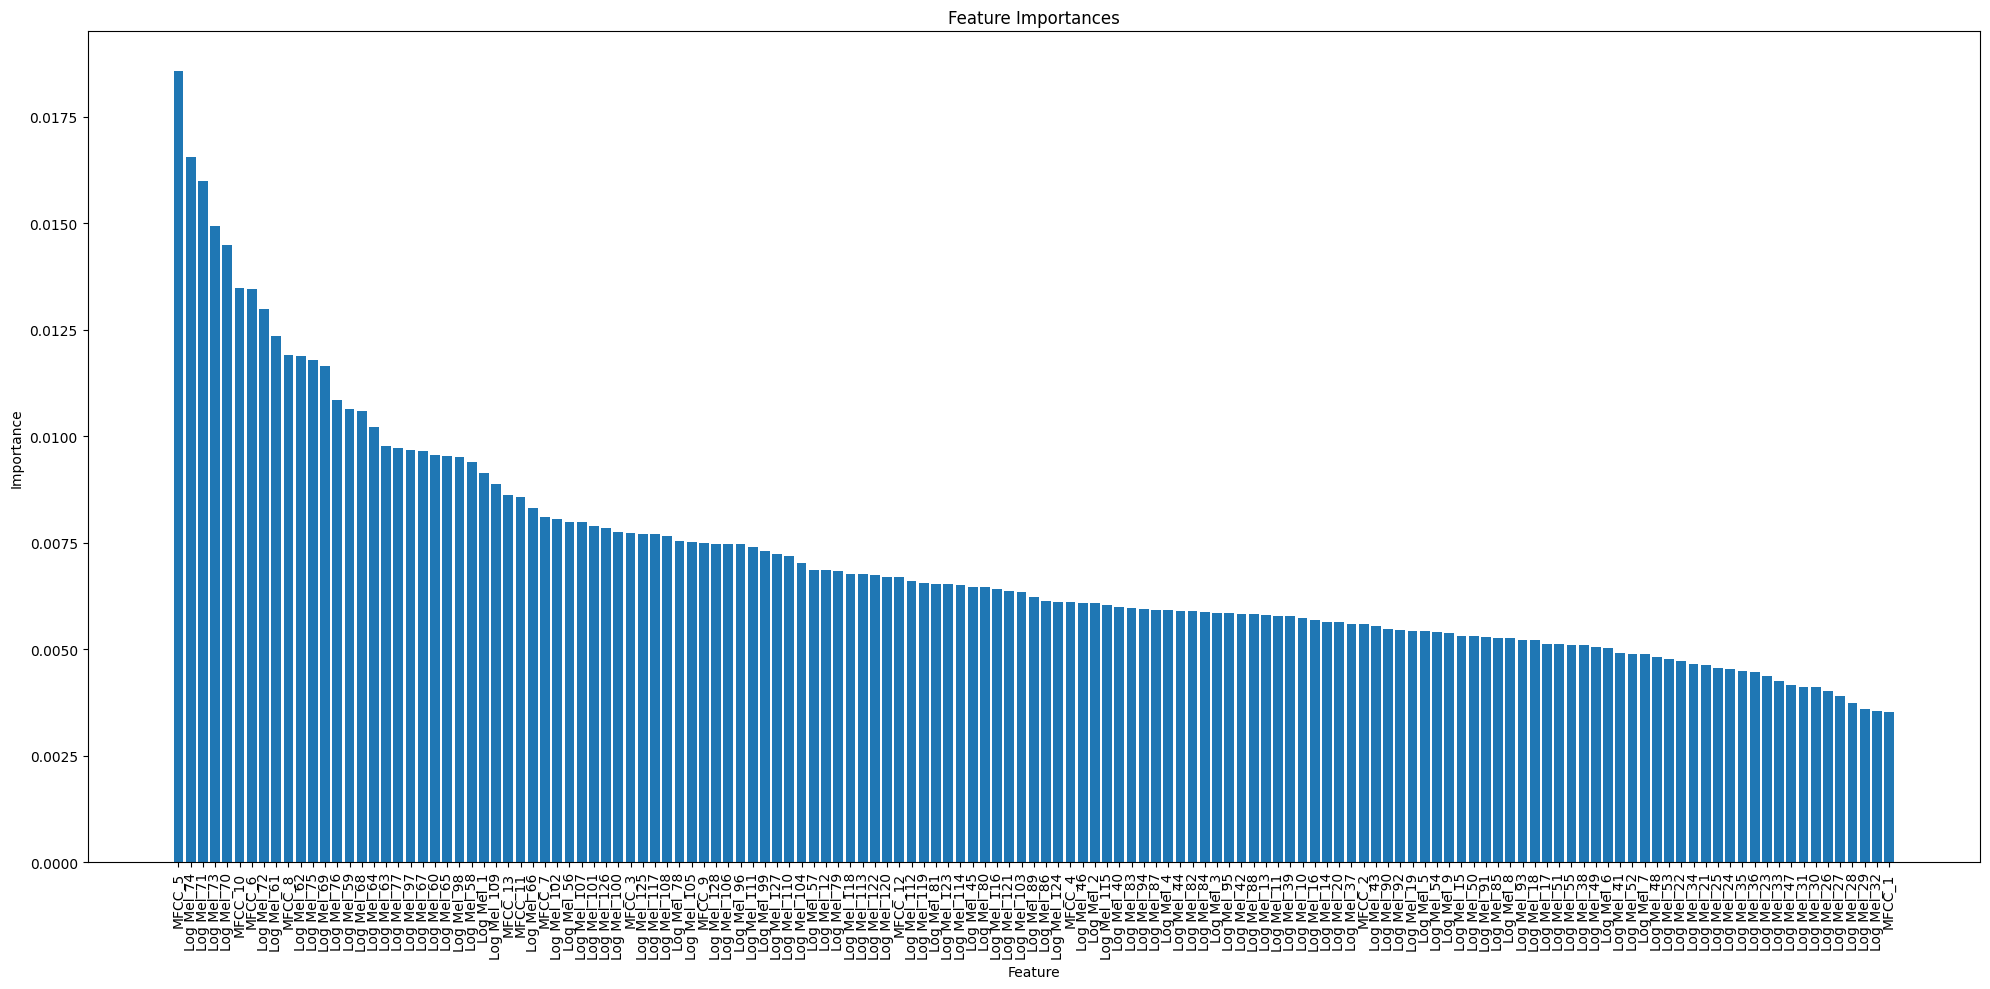

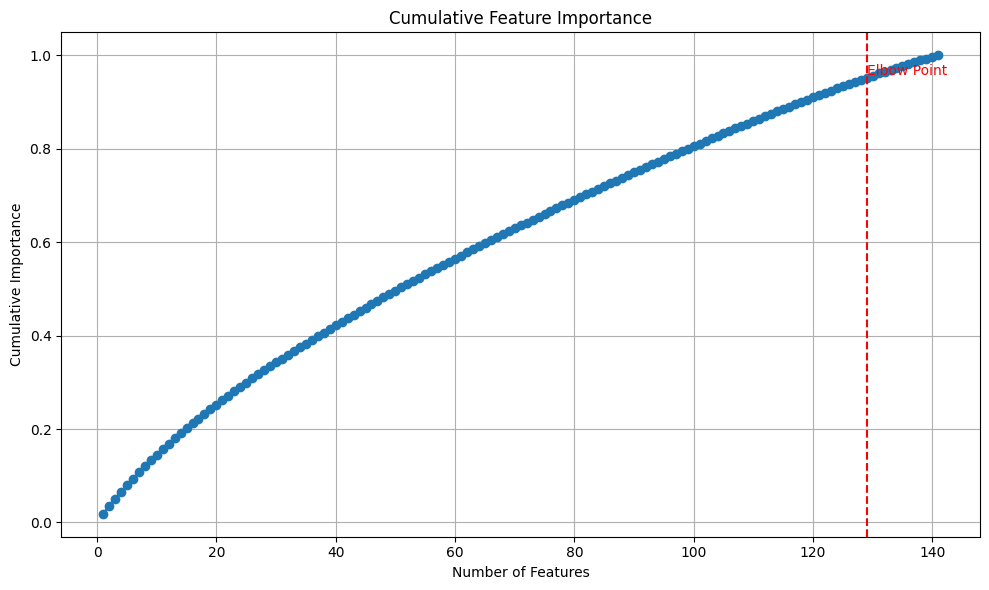

Elbow Point (95% cumulative importance): 129 features


In [15]:


# Define feature names with consistent indexing (1-based for display clarity)
feature_names = ['MFCC_{}'.format(i + 1) for i in range(13)] + \
                ['Log Mel_{}'.format(i + 1) for i in range(128)] 

# Assuming clf_combined is your trained model with combined features
importances = clf_combined.feature_importances_
indices = np.argsort(importances)[::-1]  # Sort indices by importance

# Plotting all features
plt.figure(figsize=(20, 10))
plt.bar(range(len(importances)), importances[indices], align='center')
plt.xticks(range(len(importances)), [feature_names[i] for i in indices], rotation=90)
plt.title('Feature Importances')
plt.ylabel('Importance')
plt.xlabel('Feature')
plt.tight_layout()
plt.show()

# Calculate cumulative importance
cumulative_importance = np.cumsum(importances[indices])

# Plot cumulative importance
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative_importance) + 1), cumulative_importance, marker='o', linestyle='--')
plt.xlabel('Number of Features')
plt.ylabel('Cumulative Importance')
plt.title('Cumulative Feature Importance')
plt.grid(True)

# Identify the elbow point (e.g., 95% cumulative importance)
elbow_point = np.argmax(cumulative_importance >= 0.95) + 1  # 95% threshold
plt.axvline(x=elbow_point, color='r', linestyle='--')
plt.text(elbow_point, cumulative_importance[elbow_point - 1], 'Elbow Point', color='r', verticalalignment='bottom')

plt.tight_layout()
plt.show()

print(f"Elbow Point (95% cumulative importance): {elbow_point} features")


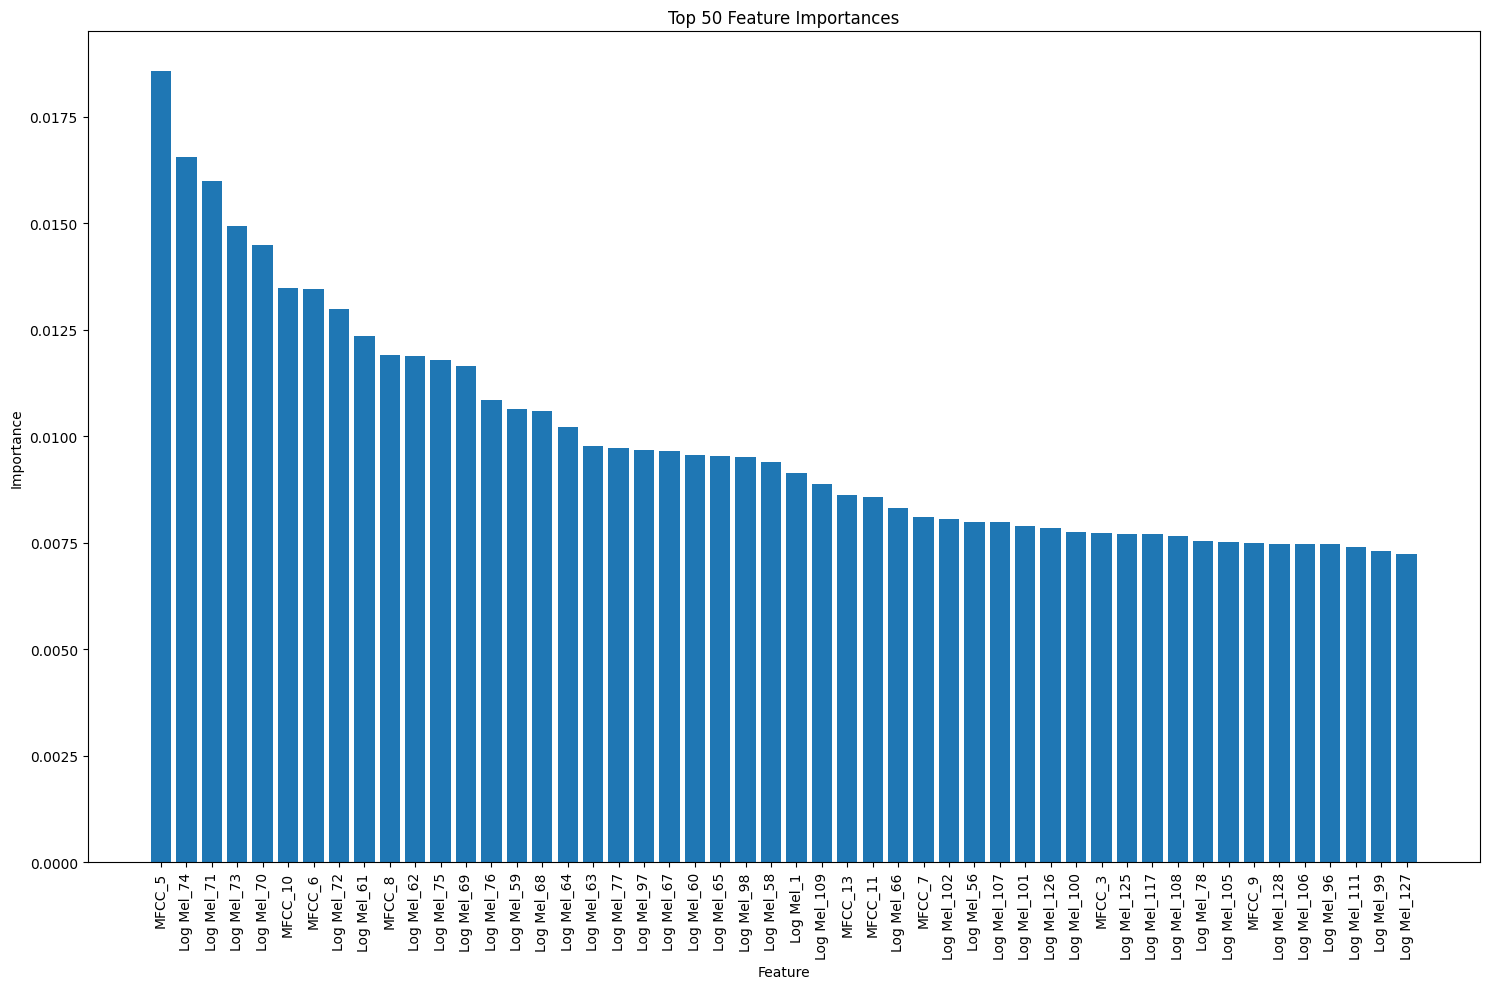

In [16]:
# Define feature names starting from 1
feature_names = ['MFCC_{}'.format(i + 1) for i in range(13)] + \
                ['Log Mel_{}'.format(i + 1) for i in range(128)]

# Assuming clf_combined is your trained model with combined features
importances = clf_combined.feature_importances_
indices = np.argsort(importances)[::-1]  # Sort indices by importance

# Define the number of features to display
N = 50

# Plotting top N features
plt.figure(figsize=(15, 10))
plt.bar(range(N), importances[indices[:N]], align='center')
plt.xticks(range(N), [feature_names[i] for i in indices[:N]], rotation=90)
plt.title(f'Top {N} Feature Importances')
plt.ylabel('Importance')
plt.xlabel('Feature')
plt.tight_layout()
plt.show()

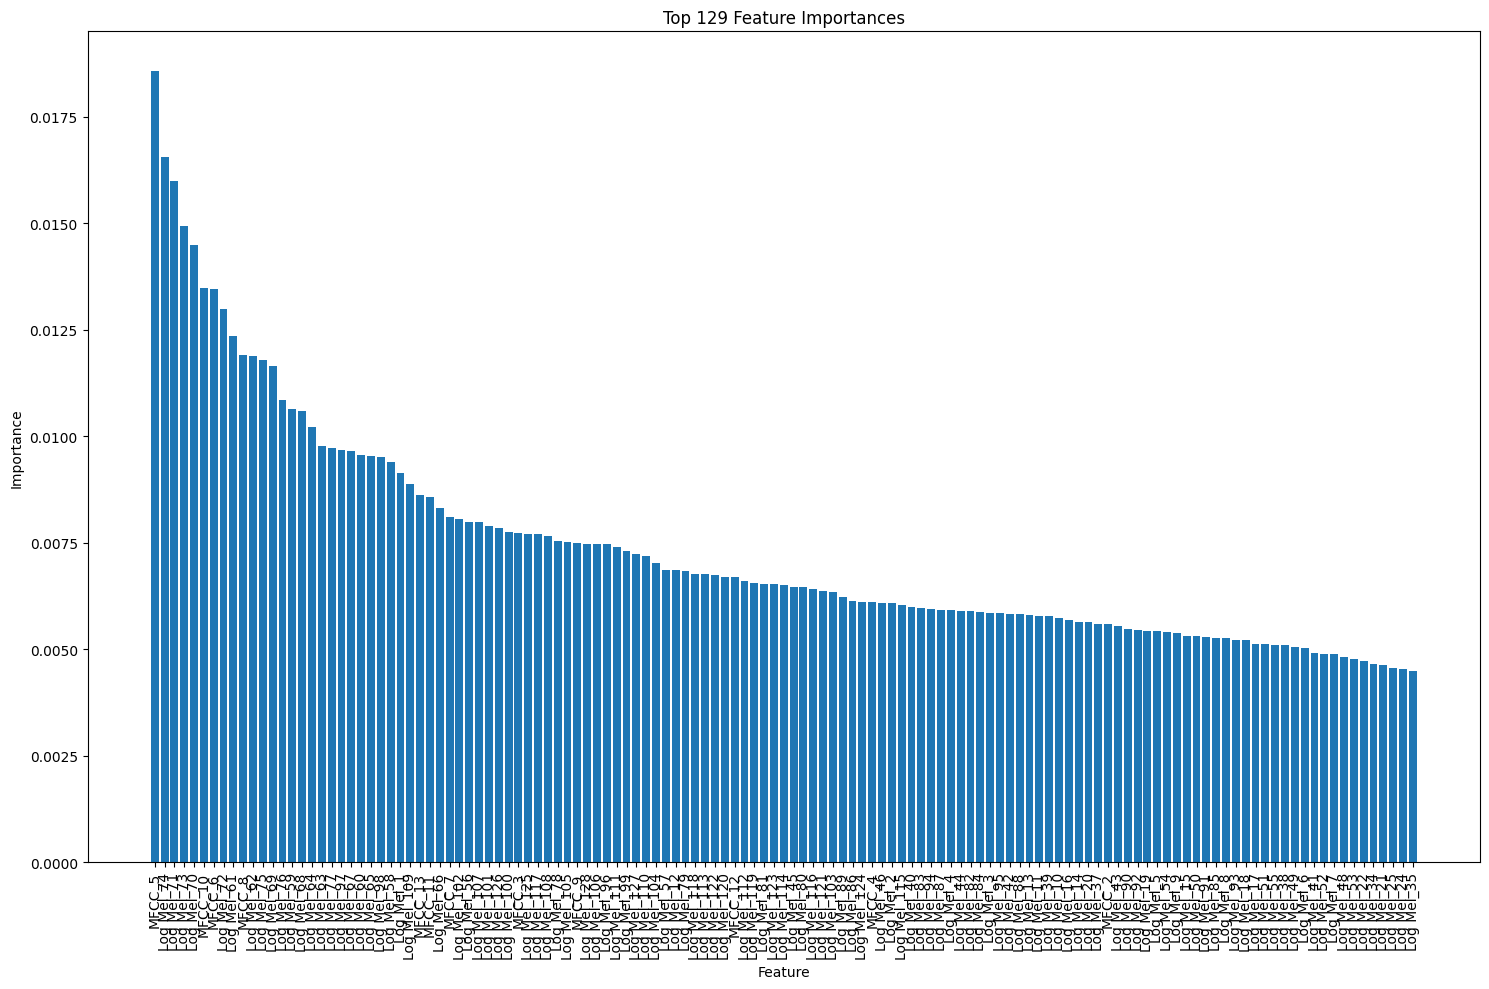

In [17]:
# Define feature names starting from 1
feature_names = ['MFCC_{}'.format(i + 1) for i in range(13)] + \
                ['Log Mel_{}'.format(i + 1) for i in range(128)]

# Assuming clf_combined is your trained model with combined features
importances = clf_combined.feature_importances_
indices = np.argsort(importances)[::-1]  # Sort indices by importance

# Define the number of features to display
N = 129

# Plotting top N features
plt.figure(figsize=(15, 10))
plt.bar(range(N), importances[indices[:N]], align='center')
plt.xticks(range(N), [feature_names[i] for i in indices[:N]], rotation=90)
plt.title(f'Top {N} Feature Importances')
plt.ylabel('Importance')
plt.xlabel('Feature')
plt.tight_layout()
plt.show()

In [18]:
def plot_spectrogram_feature(audio, sr, feature_idx, feature_type, title):
    if feature_type == 'MFCC':
        # Extract MFCC features
        mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=13)
        plt.figure(figsize=(10, 4))
        plt.plot(mfcc[feature_idx], label=f'MFCC {feature_idx+1}')
        plt.title(f'{title}: MFCC {feature_idx+1}')
        plt.xlabel('Time')
        plt.ylabel('MFCC Coefficients')
        plt.legend()
        plt.tight_layout()
        plt.show()
    else:
        # Extract Mel spectrogram
        mel_spec = librosa.feature.melspectrogram(y=audio, sr=sr, n_mels=128)
        log_mel_spec = librosa.power_to_db(mel_spec)
        plt.figure(figsize=(10, 4))
        librosa.display.specshow(log_mel_spec, sr=sr, x_axis='time', y_axis='mel')
        plt.axhline(y=feature_idx - 13, color='r', linestyle='--', label=f'Log Mel {feature_idx-13+1}')
        plt.title(f'{title}: Log Mel {feature_idx-13+1}')
        plt.xlabel('Time')
        plt.ylabel('Frequency Bin')
        plt.colorbar(format='%+2.0f dB')
        plt.legend()
        plt.tight_layout()
        plt.show()


Top 10 Combined Feature Importances:


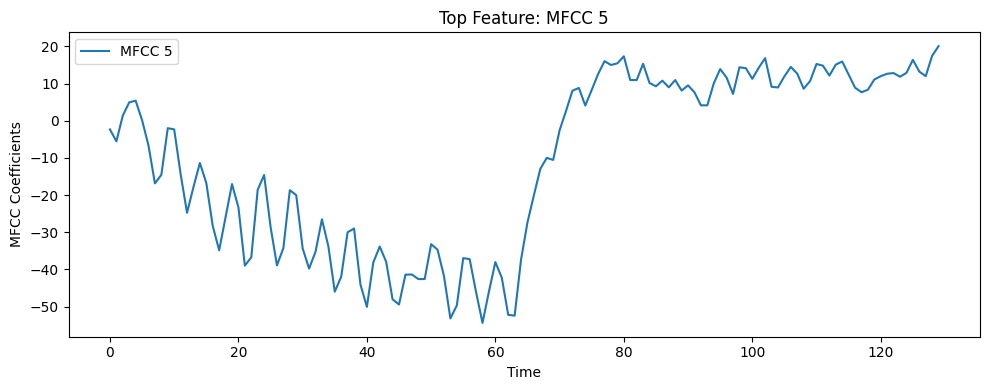

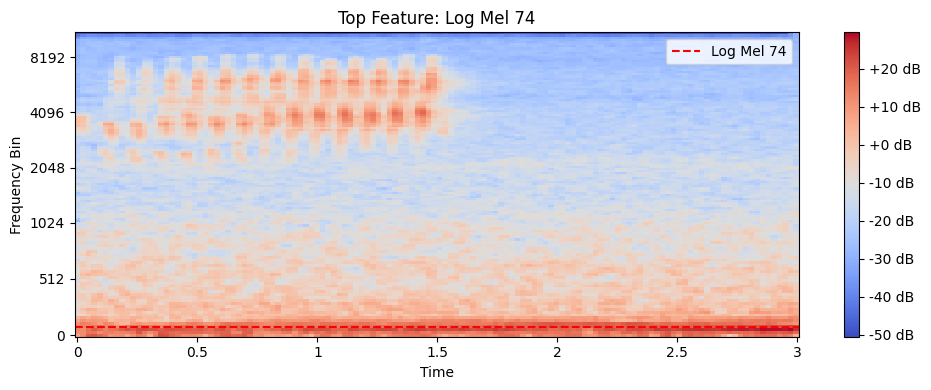

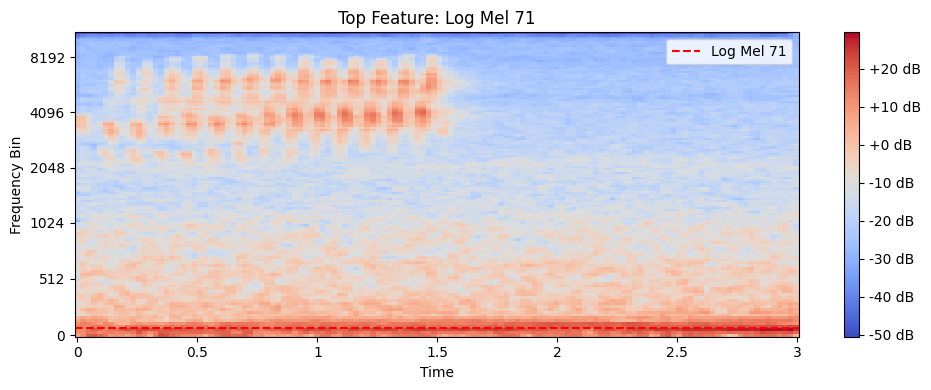

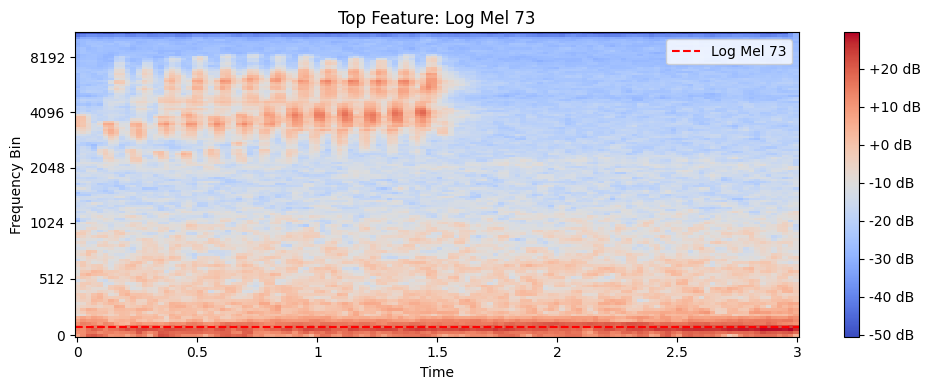

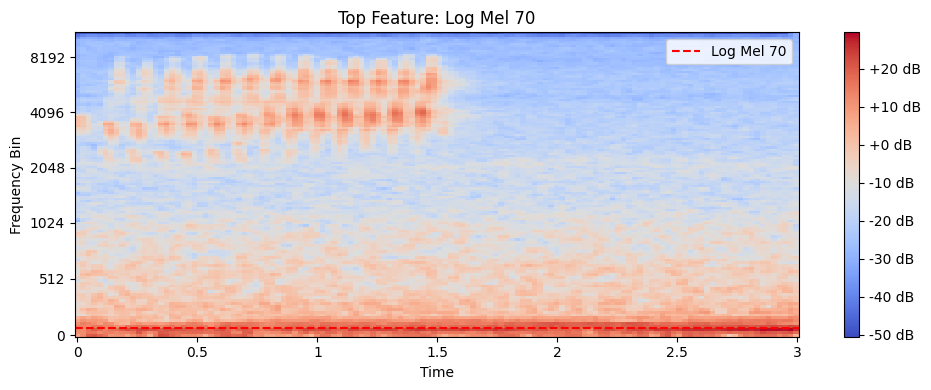

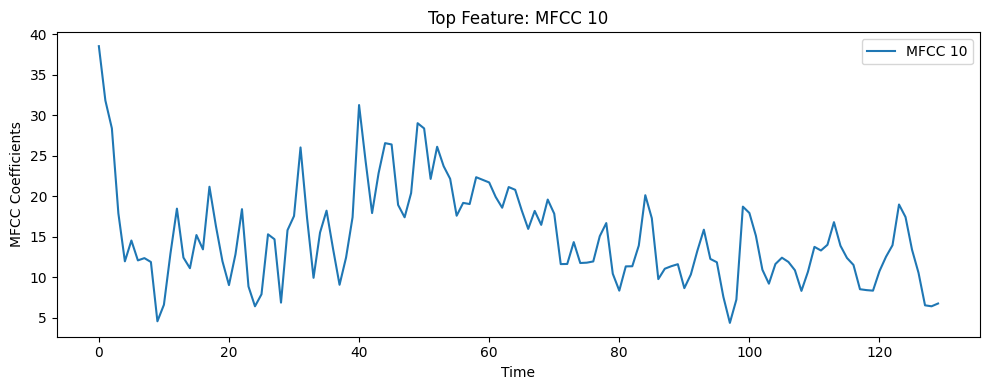

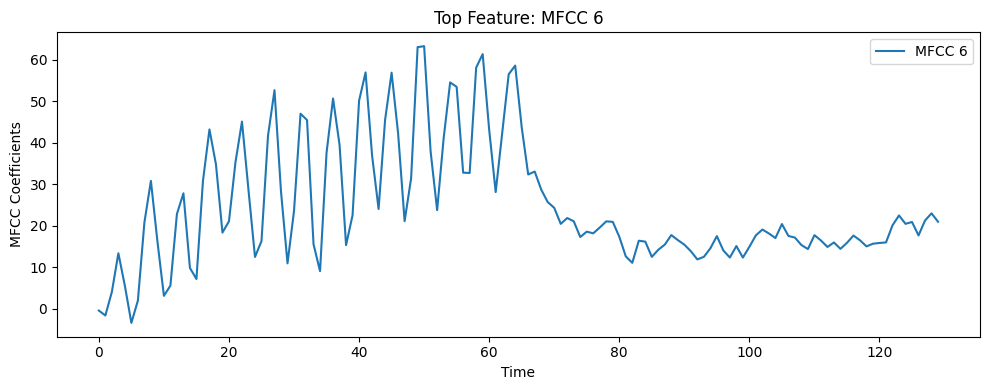

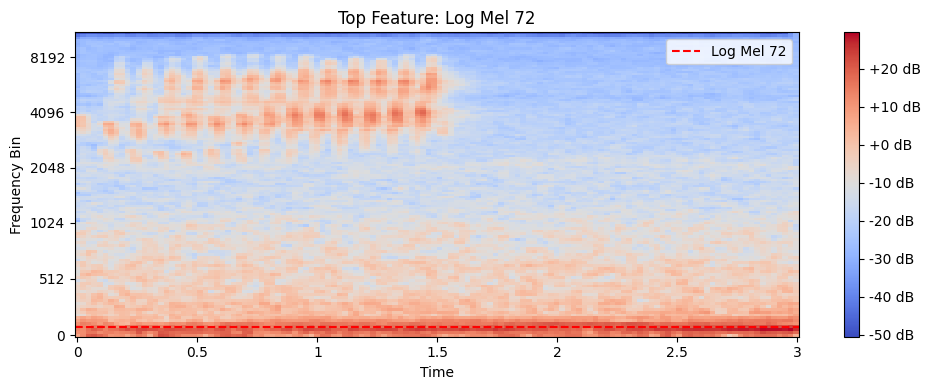

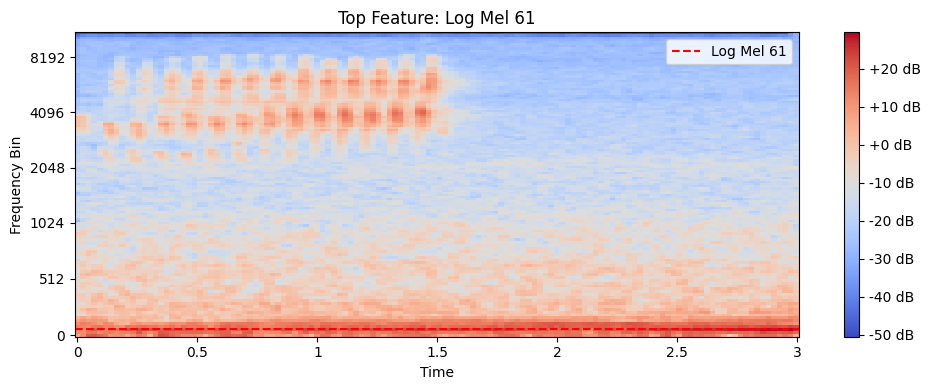

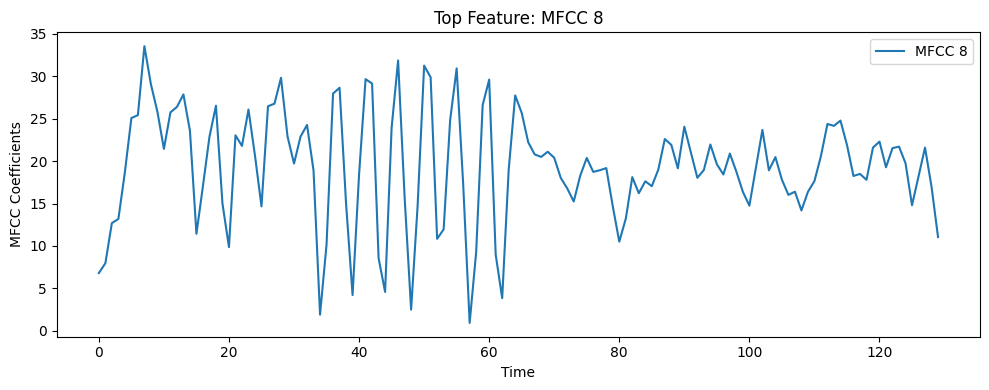

Bottom 10 Combined Feature Importances:


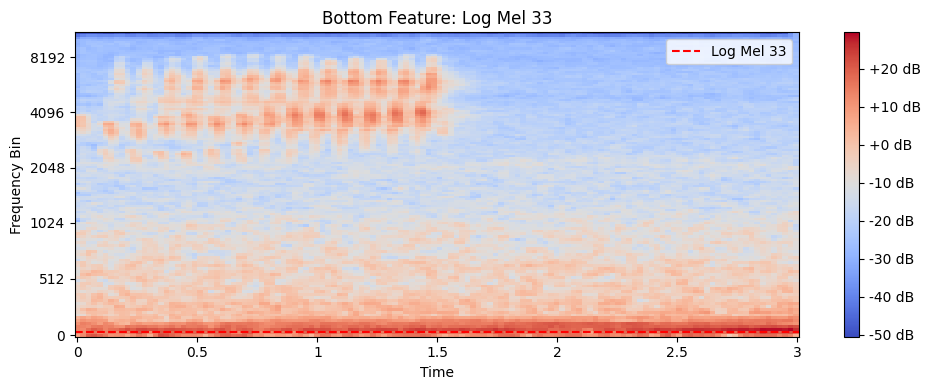

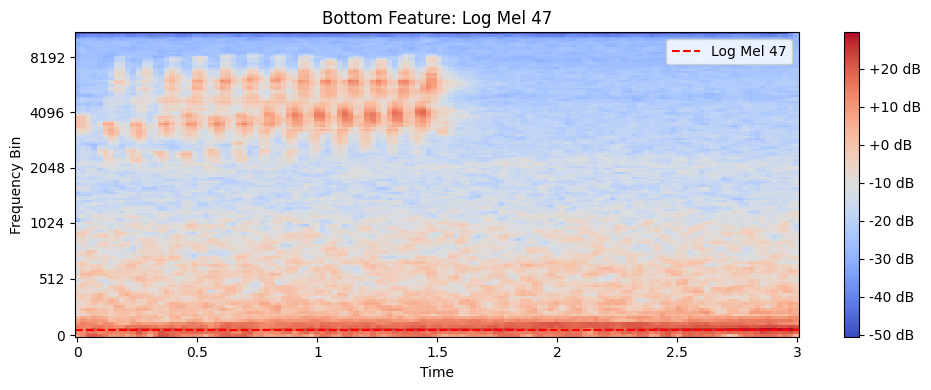

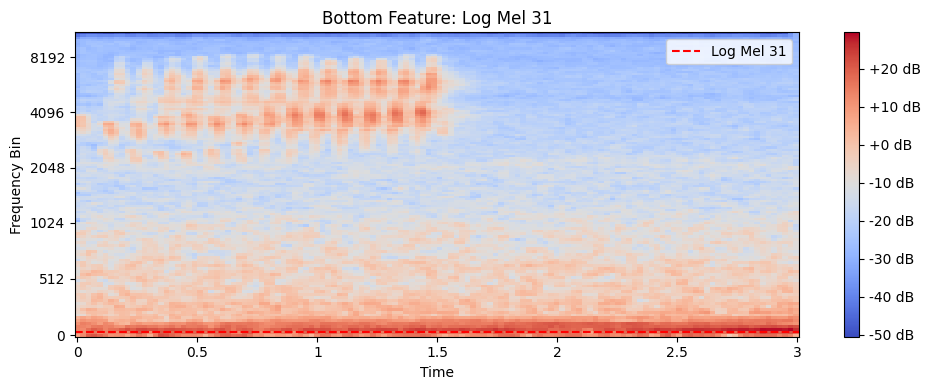

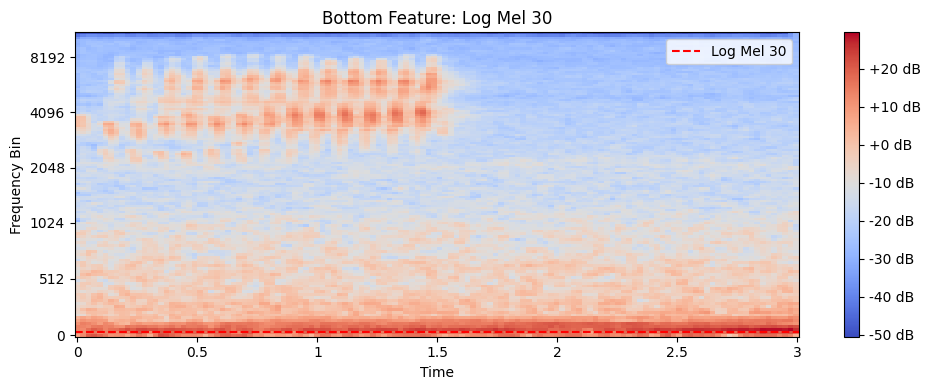

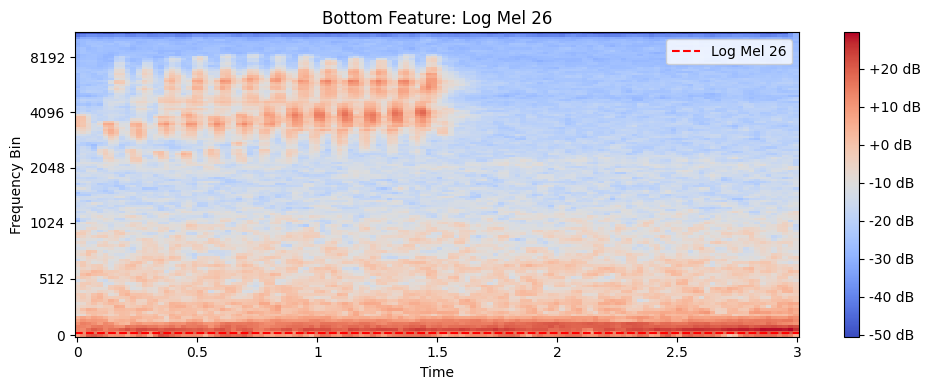

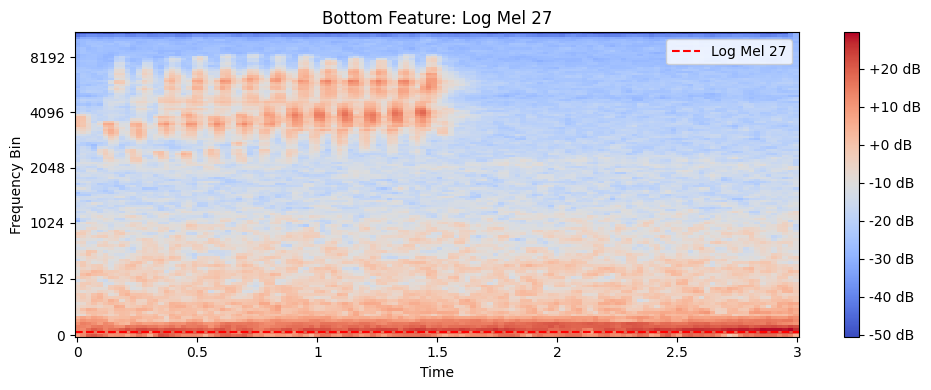

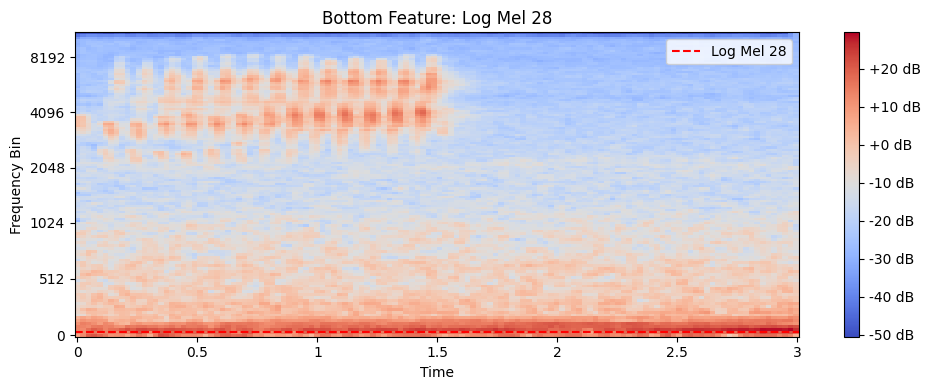

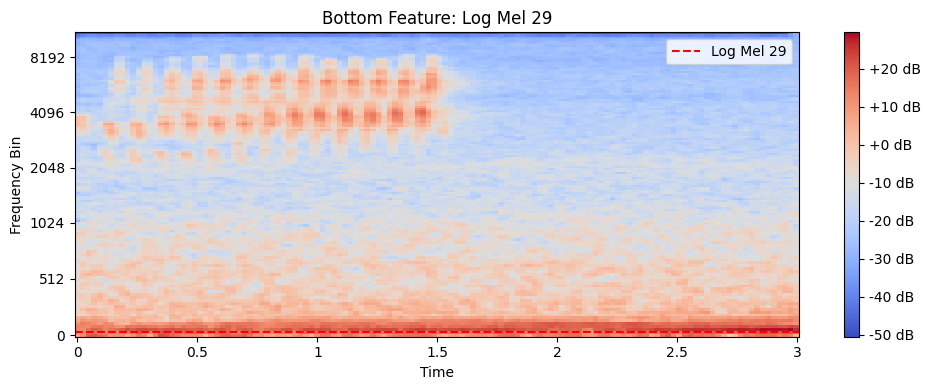

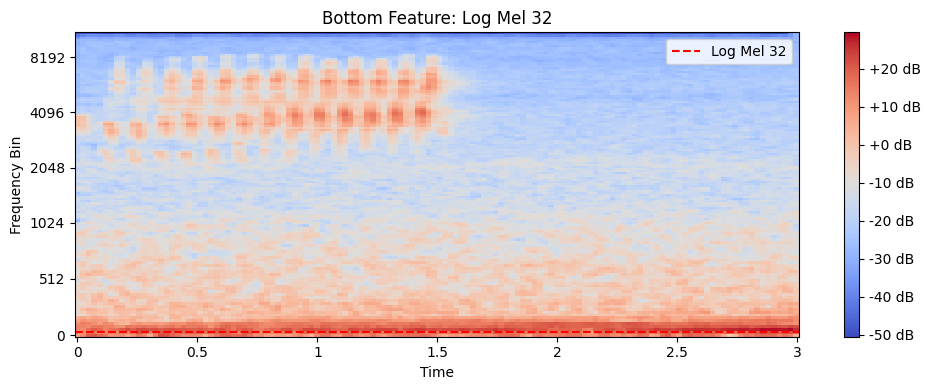

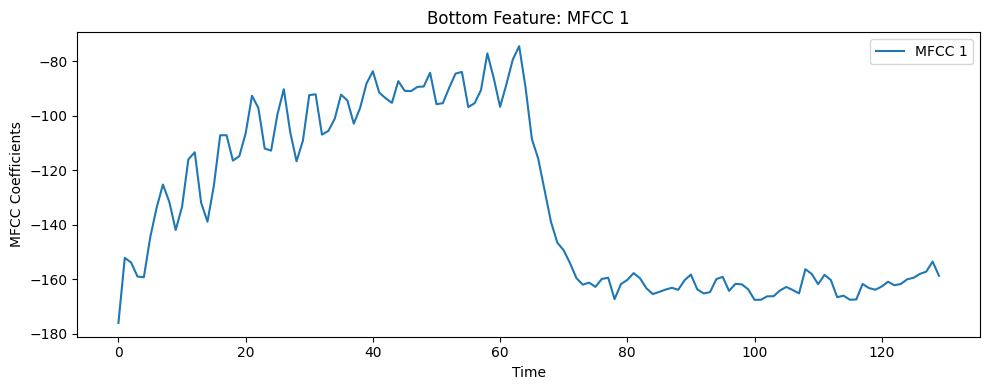

In [19]:

# Define feature names
feature_names = ['MFCC_{}'.format(i) for i in range(13)] + \
                ['Log Mel_{}'.format(i) for i in range(128)]

# Assuming clf_combined is your trained model with combined features
importances = clf_combined.feature_importances_
indices = np.argsort(importances)[::-1]  # Sort indices by importance

# Get the top 10 features
top_combined_indices = indices[:10]

# Get the bottom 10 features
bottom_combined_indices = indices[-10:]

# Example audio file (adjust to your context)
example_audio_path = file_paths[0]
audio, sr = librosa.load(example_audio_path, sr=22050)

print("Top 10 Combined Feature Importances:")
for i in top_combined_indices:
    feature_type = 'MFCC' if i < 13 else 'Log Mel'
    plot_spectrogram_feature(audio, sr, i, feature_type, 'Top Feature')

print("Bottom 10 Combined Feature Importances:")
for i in bottom_combined_indices:
    feature_type = 'MFCC' if i < 13 else 'Log Mel'
    plot_spectrogram_feature(audio, sr, i, feature_type, 'Bottom Feature')


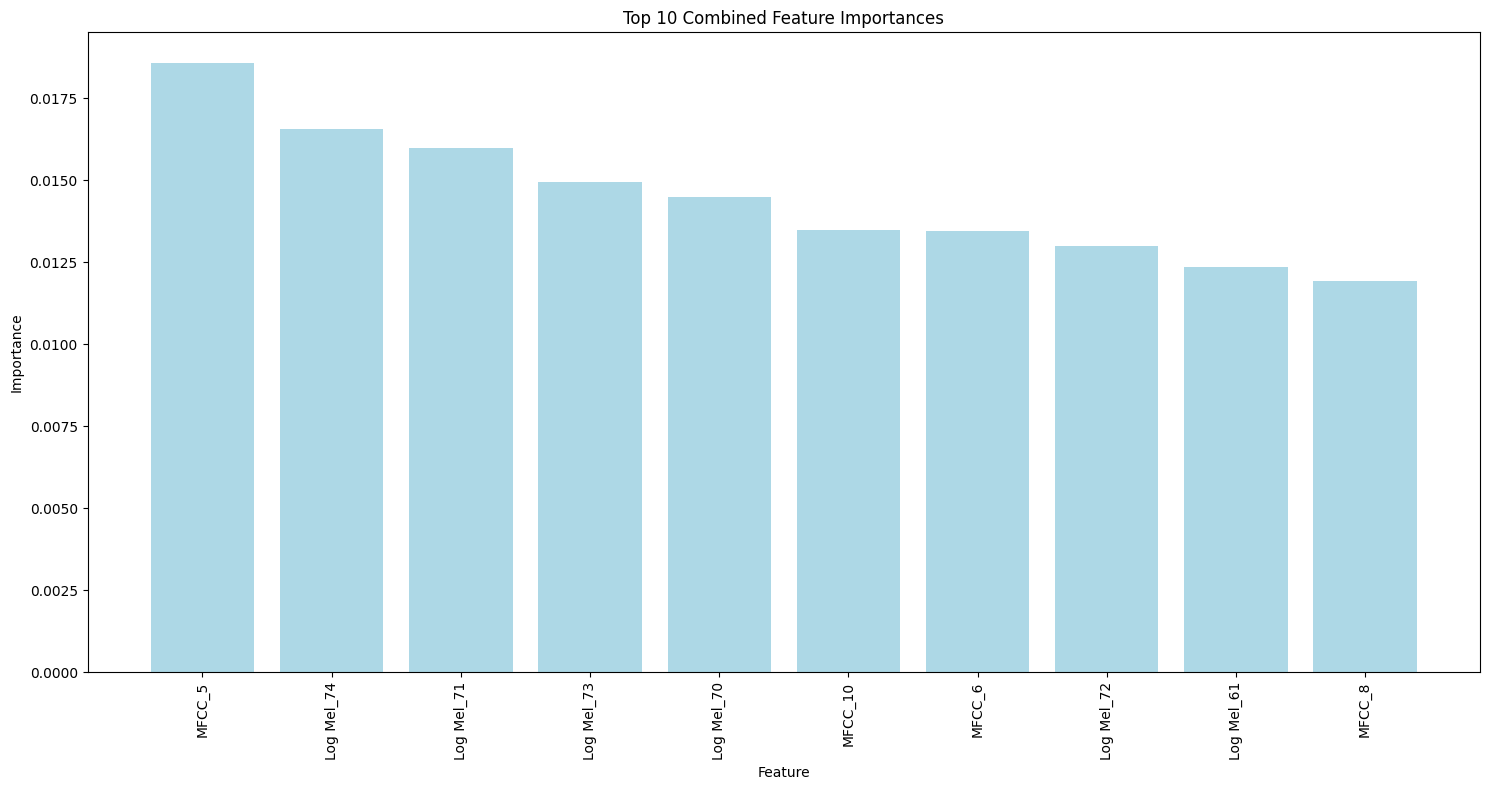

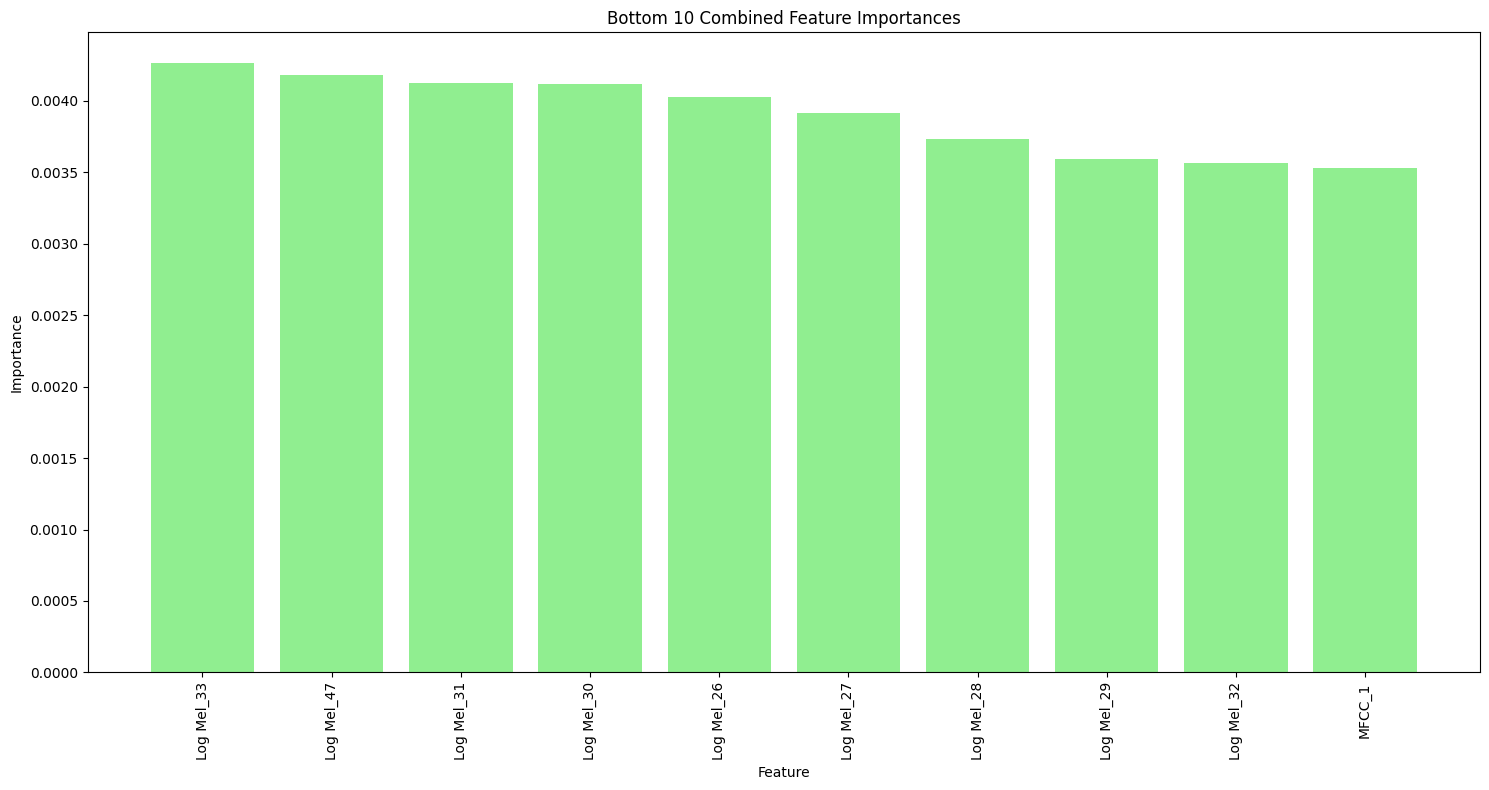

In [20]:

# Define feature names starting from 1
feature_names = ['MFCC_{}'.format(i + 1) for i in range(13)] + \
                ['Log Mel_{}'.format(i + 1) for i in range(128)] 

# Assuming clf_combined is your trained model with combined features
importances = clf_combined.feature_importances_
indices = np.argsort(importances)[::-1]  # Sort indices by importance

# Get the top 10 features
top_combined_indices = indices[:10]

# Get the bottom 10 features
bottom_combined_indices = indices[-10:]

# Plotting top 10 combined features
plt.figure(figsize=(15, 8))
plt.bar(range(10), importances[top_combined_indices], align='center', color='lightblue')
plt.xticks(range(10), [feature_names[i] for i in top_combined_indices], rotation=90)
plt.title('Top 10 Combined Feature Importances')
plt.ylabel('Importance')
plt.xlabel('Feature')
plt.tight_layout()
plt.show()

# Plotting bottom 10 combined features
plt.figure(figsize=(15, 8))
plt.bar(range(10), importances[bottom_combined_indices], align='center', color='lightgreen')
plt.xticks(range(10), [feature_names[i] for i in bottom_combined_indices], rotation=90)
plt.title('Bottom 10 Combined Feature Importances')
plt.ylabel('Importance')
plt.xlabel('Feature')
plt.tight_layout()
plt.show()


In [54]:

y3_scores = clf_combined.predict_proba(X3_test)

In [55]:
# Binarize the labels
y3_test_binarized = label_binarize(y3_test, classes=np.unique(y3_train))

In [56]:
n_classes = y3_test_binarized.shape[1]
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y3_test_binarized[:, i], y3_scores[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

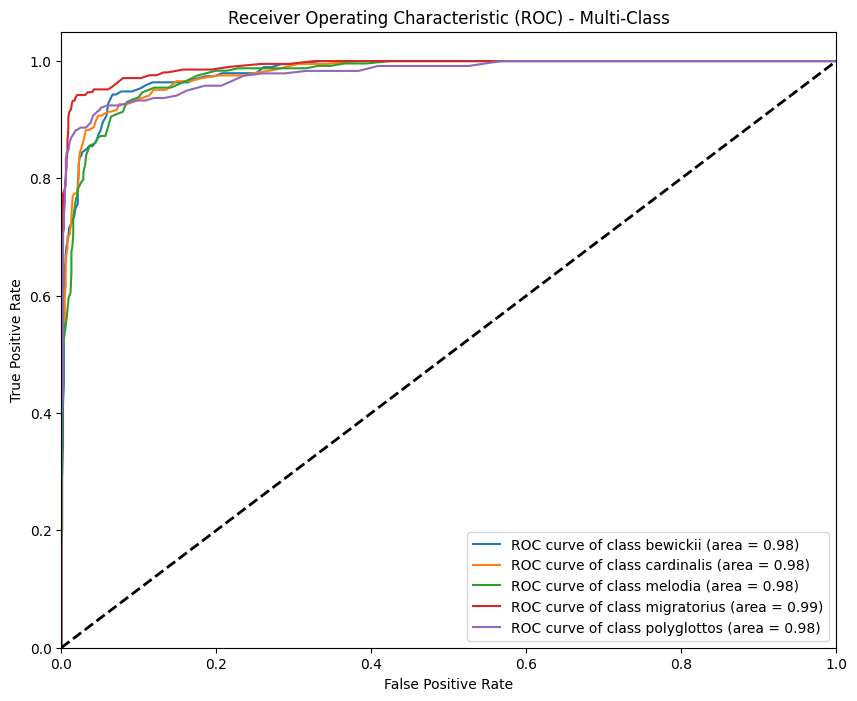

In [57]:
plt.figure(figsize=(10, 8))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f'ROC curve of class {label_encoder.classes_[i]} (area = {roc_auc[i]:.2f})')
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) - Multi-Class')
plt.legend(loc="lower right")
plt.show()


The ROC curve shown represents how well my model can identify different bird species from their sounds. Each line on the graph stands for a different bird species. The closer these lines are to the top-left corner of the chart, the better my model is at identifying that specific bird species correctly.

The chart uses Area Under the Curve, to show how accurate the predictions are. The values range from 0.98 to 0.99 for different species, which is really high. This means that my model does an excellent job at figuring out which sounds belong to which species, with very few mistakes.

The line going diagonally from the bottom left to the top right represents a guesswork model, just randomly guessing the bird species. My model's lines are way above this diagonal line, which tells us that it's doing much better than just guessing.

One particular species, labeled as "migratorius," has an AUC of 0.99, which is the highest among the species tested. This means the model is almost perfect at identifying this species. The other species have AUC values of 0.98, which are also very good but slightly lower than the "migratorius."

Overall, this graph shows that my model is reliable and effective in recognizing bird species from sounds.